## 걷기여행길 난이도 분석

### Import & Data Setting



In [17]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import *
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from konlpy.tag import Twitter
import scipy as sp
import lightgbm as lgb
import requests
import pandas as pd 
from scipy import stats
import re
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from scipy.stats import norm, skew 
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [3]:
def data_setting():
    road = pd.read_csv("한국관광공사_걷기여행길 관광정보_20160906.csv", encoding="cp949")
    road_f = road.filter(items=(['걷는길 명칭', '코스명', '코스설명', '지역1', '난이도', '거리', '상세거리(km)', '소개', '소요시간']))
    road_ff = road_f.dropna()
    
    no = road_ff[road_ff['난이도'].str.contains("보통")]
    easy = road_ff[road_ff['난이도'].str.contains("쉬움")]
    di = road_ff[road_ff['난이도'].str.contains("어려움")]
    very_easy = road_ff[road_ff['난이도'].str.contains("매우쉬움")]
    diff = road_ff[road_ff['난이도'].str.contains("매우어려움")]


    no['class'] = "보통"
    no['category'] = 3

    easy['class'] = "쉬움"
    easy['category'] = 2

    di['class'] = "어려음"
    di['category'] = 4

    very_easy['class'] = "매우쉬움"
    very_easy['category'] = 1

    diff['class'] = "매우어려움"
    diff['category'] = 5

    total = pd.concat([no, easy, di, very_easy, diff]).reset_index(drop=True)

    total = total.drop("난이도",axis=1)
    
    return total

total = data_setting()

In [4]:
total.tail()

,걷는길 명칭,코스명,코스설명,지역1,거리,상세거리(km),소개,소요시간,class,category
1710,빛고을산들길,03코스,동적골~무등산 자주봉(1.8km)~금당산(8km)~풍암호수(11km),광주 광산구,10~15Km미만,11.5,시작점에서부터 끝까지 도심과 자연을 들락날락하도록 구성된 노정처럼 3코스 곳곳에는 ...,6시간,매우어려움,5
1711,예향천리 장수마실길,백두대간 마실길 03코스,주촌민속마을~ (0.5km)논개생가~(9.1km)동명마을~(5.5km)문성마을~(4...,전북 장수군,15~20Km미만,19.2,소백산맥에서 노령산맥으로 이어지는 산줄기인 수분재에 위치한 금강의 발원천인 뜬봉샘을...,7시간,매우어려움,5
1712,대전둘레산길,2구간,금동고개 소나무암 ~ 돌탑봉 ~ 떡갈봉 ~ 삼각점봉 ~ 용궁사갈림길 ~ 대전시계 ~...,대전 중구,1Km미만,13.1,만인산은 태봉산이라고도 부르는데 조선 태조 이성계의 태실이 이곳에 있기 때문에 붙여...,7시간30분,매우어려움,5
1713,대전둘레산길,4구간,삼괴동 덕산마을 느티나무 ~ 닭재 ~ 망덕봉 ~ 임도 ~ 동오리고개 ~ 식장산 해돋...,대전 중구,10~15Km미만,13.6,"식장산(598m)은 대전에서 가장 높은 산으로 보만식계로 불리는 보문산, 만인산, ...",7시간 30분,매우어려움,5
1714,여수 갯가길,A코스,우두리항 ~ 돌산공원 ~ 신추(거북선대교) ~ 진목마을 ~ 밀듬벙 ~ 범바위 ~ 용...,전남 여수시,20~100Km미만,24.3,첫 출발을 해서 상쾌한 기분으로 신작로를 몇 발자국 걷다보면 가장 먼저 만나는 아름...,7시간,매우어려움,5


### 1. 분석(소개 + 자연어처리 분석)

In [5]:
from konlpy.tag import Twitter
from konlpy.tag import *
hannanum = Hannanum()
kkma = Kkma()
twitter = Twitter()

def tokenize_pos(doc):
    return ['/'.join(t) for t in twitter.pos(doc)]

In [6]:
clf = Pipeline([
    ("vect", TfidfVectorizer(tokenizer=tokenize_pos, ngram_range=(1,10))), 
    ("clf", MultinomialNB(alpha=0.01))
])

In [7]:
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(total['소개'], total['class'], \
                                                    test_size=0.4, random_state=0)

len(X_train_a),len(X_test_a),len(y_train_a),len(y_test_a)

(1029, 686, 1029, 686)

Train 

Train confusion_matrix 

[[ 61   0   0   0   0]
 [  0  16   0   0   0]
 [  1   4 561   1   2]
 [ 40   0   1 220   0]
 [  0  12   1   0 109]] 


Train classification_report 

             precision    recall  f1-score   support

       매우쉬움       0.60      1.00      0.75        61
      매우어려움       0.50      1.00      0.67        16
         보통       1.00      0.99      0.99       569
         쉬움       1.00      0.84      0.91       261
        어려음       0.98      0.89      0.94       122

avg / total       0.96      0.94      0.95      1029
 


Train accuracy_score 

0.94 




Test 

Test confusion_matrix 

[[  0   0  13  25   1]
 [  0   0   4   0   5]
 [  2   0 351  27   4]
 [ 22   0 131  29   1]
 [  1   5  58   4   3]] 


Test classification_report 

             precision    recall  f1-score   support

       매우쉬움       0.00      0.00      0.00        39
      매우어려움       0.00      0.00      0.00         9
         보통       0.63      0.91      0.75       384
         쉬움     

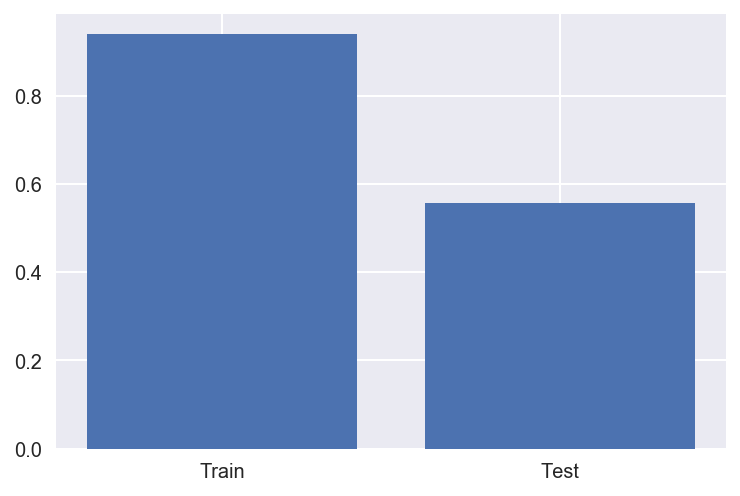

In [280]:
# def road():
model_a = clf.fit(X_train_a, y_train_a)

y_pred_a = model_a.predict(X_train_a)

print("Train", "\n")
print("Train confusion_matrix", "\n")
print(confusion_matrix(y_train_a, y_pred_a), "\n\n")
print("Train classification_report", "\n")
print(classification_report(y_train_a, y_pred_a), "\n\n")
print("Train accuracy_score", "\n")
print(round(accuracy_score(y_train_a, y_pred_a), 2), "\n\n")

print("=====================================================" , "\n\n")

y_pred_a_T = model_a.predict(X_test_a)

print("Test", "\n")
print("Test confusion_matrix", "\n")
print(confusion_matrix(y_test_a, y_pred_a_T), "\n\n")
print("Test classification_report", "\n")
print(classification_report(y_test_a, y_pred_a_T), "\n\n")
print("Test accuracy_score", "\n")
print(round(accuracy_score(y_test_a, y_pred_a_T), 2), "\n\n")

x="Train","Test"
y=accuracy_score(y_train_a, y_pred_a), accuracy_score(y_test_a, y_pred_a_T)
plt.bar(x,y)
plt.show()

### 문구 Test

In [318]:
test_test = pd.Series("위험")
y_pro_test = model_a.predict_proba(test_test)
y_pre_test = model_a.predict(test_test)

print(y_pro_test)
print(y_pre_test)

[[0.07522095 0.02260412 0.28859228 0.20703997 0.40654268]]
['어려음']


In [339]:
test_test = pd.Series("높다")
y_pro_test = model_a.predict_proba(test_test)
y_pre_test = model_a.predict(test_test)

print(y_pro_test)
print(y_pre_test)

[[0.09642703 0.00600882 0.55920769 0.30485023 0.03350623]]
['보통']


In [334]:
test_test = pd.Series("가파르다")
y_pro_test = model_a.predict_proba(test_test)
y_pre_test = model_a.predict(test_test)

print(y_pro_test)
print(y_pre_test)

[[0.031605   0.017279   0.3854227  0.08653912 0.47915418]]
['어려음']


---

### 2. 분석(소요시간 + Possible Feature Regression 분석)

In [400]:
reg_total = total.filter(items=(['지역1', '거리','소요시간','category']))

In [430]:
model_road = sm.OLS.from_formula("category ~ C(지역1)+C(거리)+C(소요시간)", data=reg_total)
result_road = model_road.fit()
sm.stats.anova_lm(result_road, typ=2)

,sum_sq,df,F,PR(>F)
C(지역1),142.019243,230.0,1.365406,6.832340e-04
C(거리),17.549729,6.0,6.467875,9.910000e-07
C(소요시간),217.740656,231.0,2.084347,1.647301e-15
Residual,565.737349,1251.0,NaN,NaN


In [468]:
model_rc = sm.OLS.from_formula("category ~ C(지역1)+C(거리)+C(소요시간)", data=reg_total)
sm.stats.anova_lm(model_rc.fit())

,df,sum_sq,mean_sq,F,PR(>F)
C(지역1),230.0,216.115025,0.939631,2.077780,2.439068e-15
C(거리),6.0,45.368923,7.561487,16.720516,1.249221e-18
C(소요시간),231.0,217.026550,0.939509,2.077511,2.227035e-15
Residual,1251.0,565.737349,0.452228,NaN,NaN


In [466]:
model2_1 = sm.OLS.from_formula("category ~ C(거리)-1", data=reg_total)
result2_1 = model2_1.fit()
print(result2_1.summary())

                            OLS Regression Results                            
Dep. Variable:               category   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     26.77
Date:                   토, 21  4 2018   Prob (F-statistic):           1.29e-30
Time:                        19:02:06   Log-Likelihood:                -1930.2
No. Observations:                1715   AIC:                             3874.
Df Residuals:                    1708   BIC:                             3912.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
C(거리)[100Km이상]        3.0000      0.74

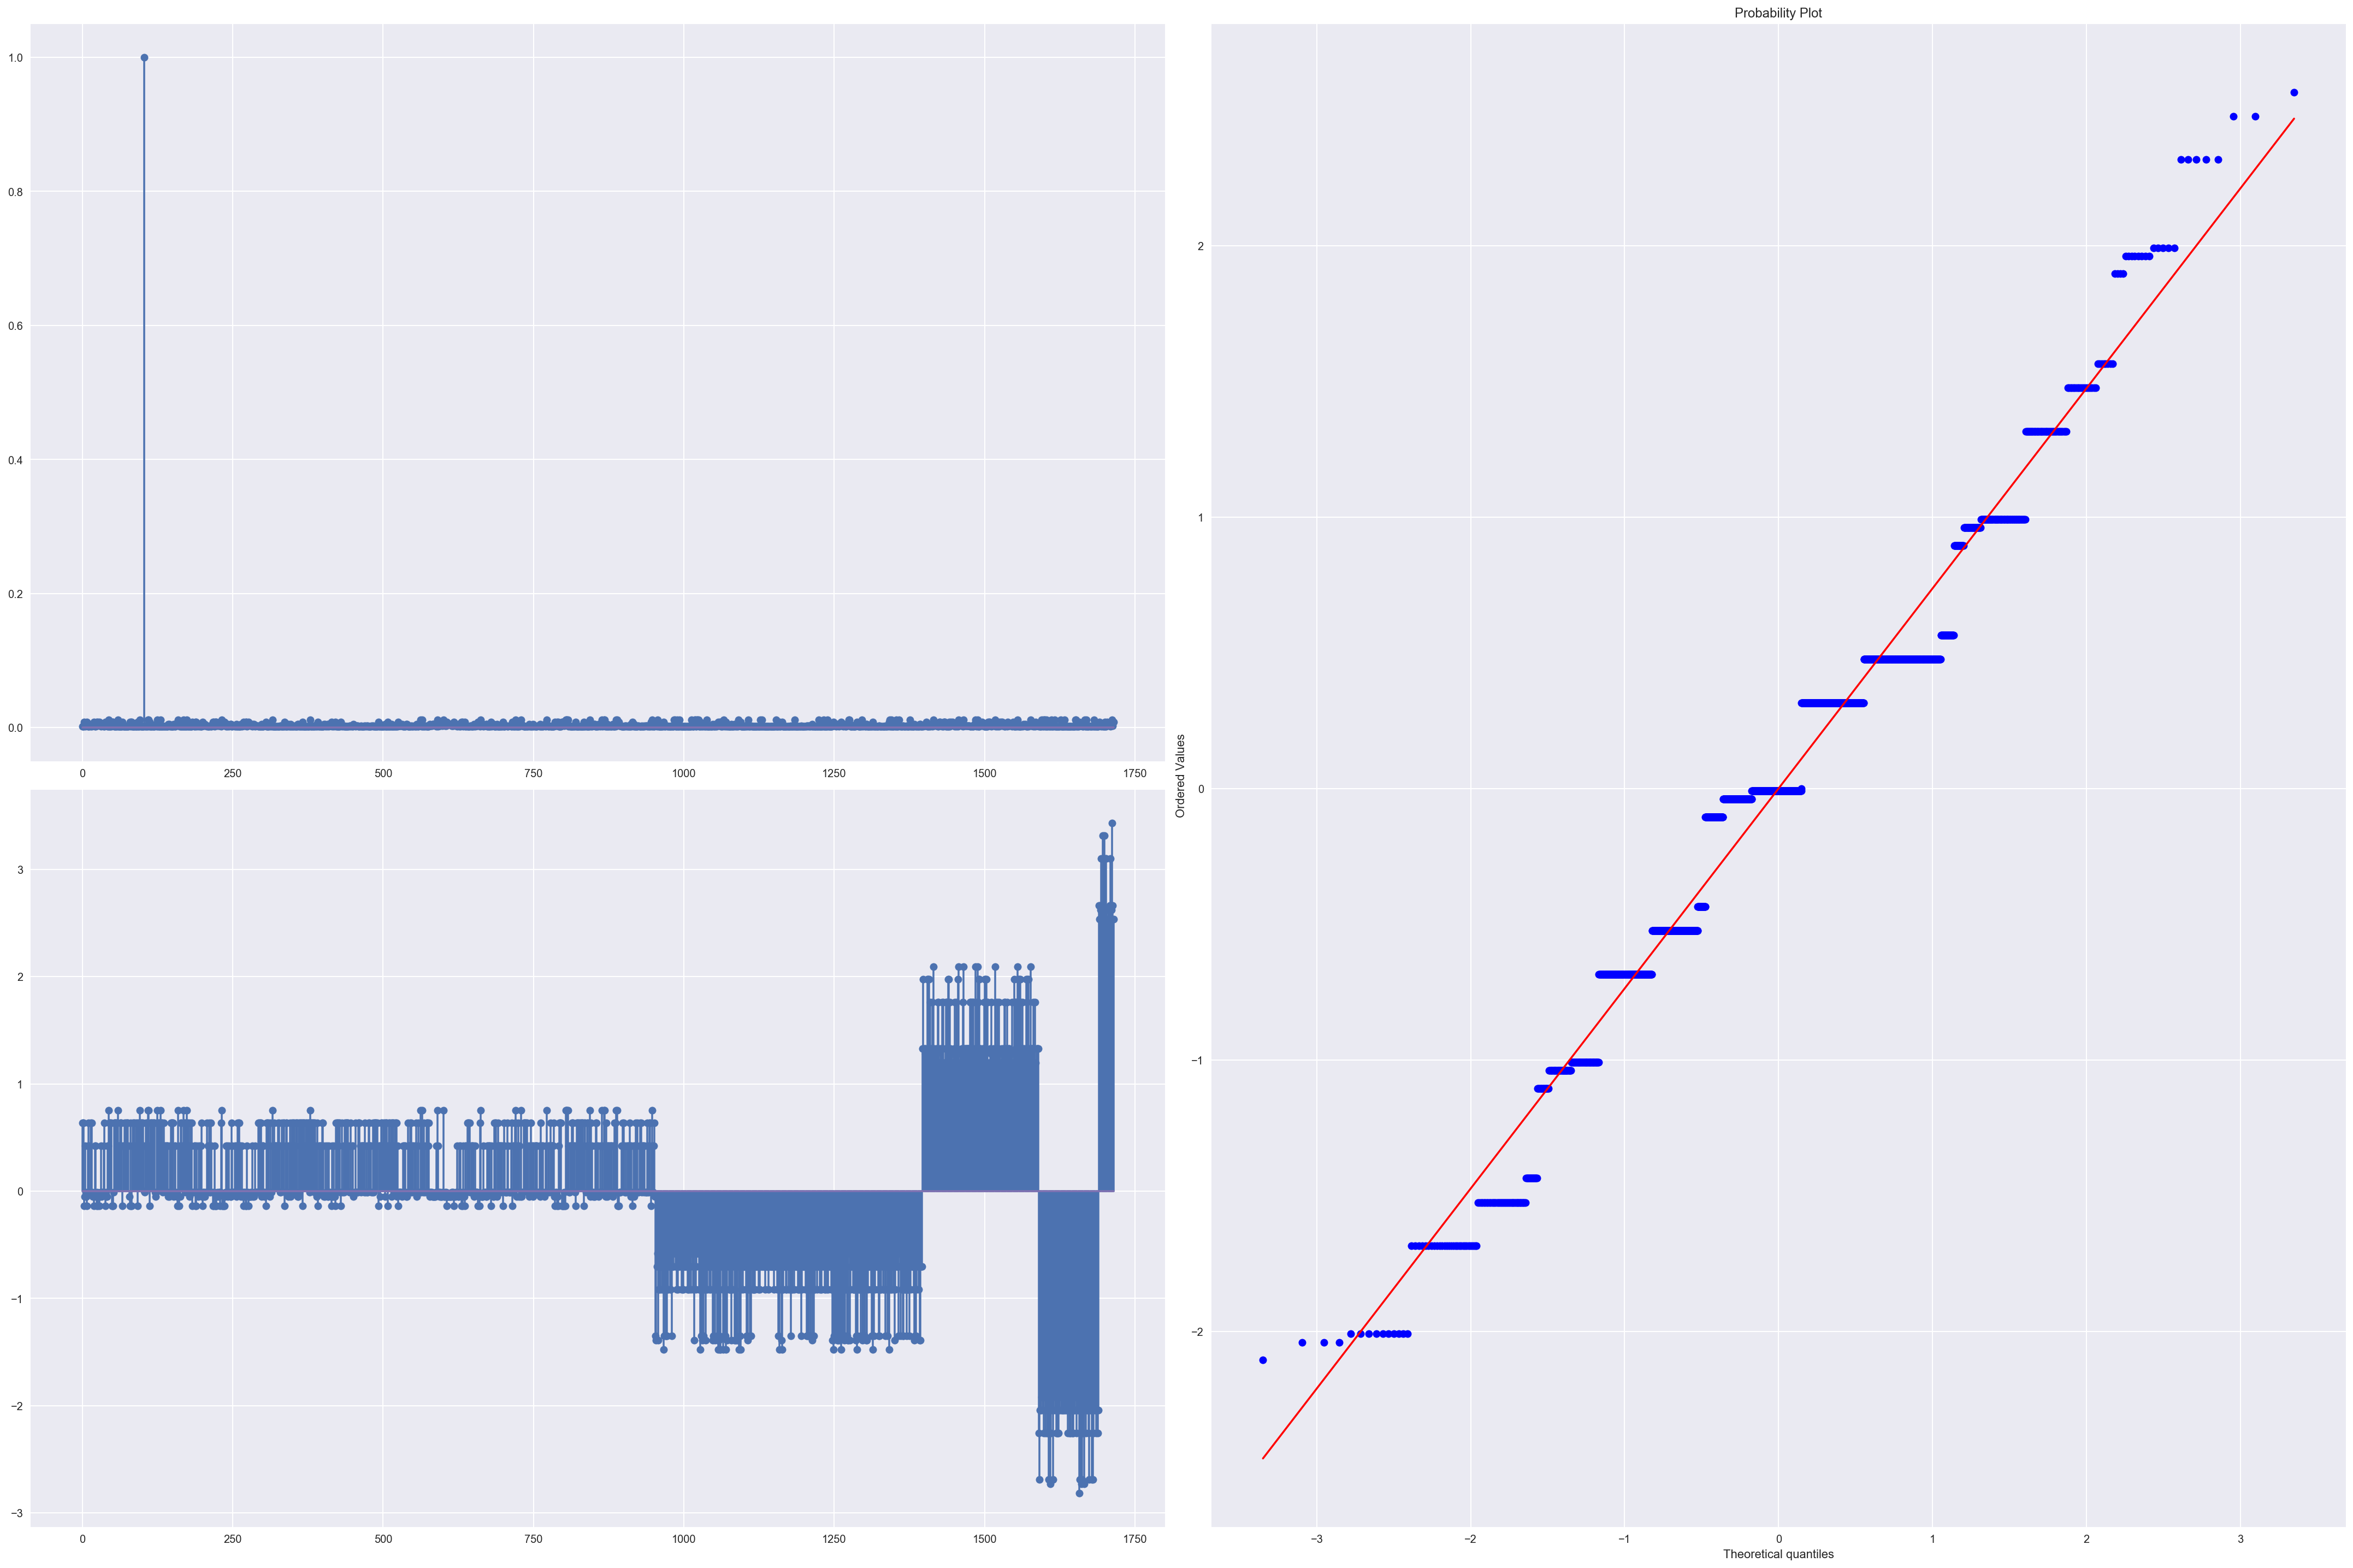

In [469]:
plt.figure(figsize=(30, 20))

ax1 = plt.subplot(221)
ax2 = plt.subplot(223)
ax3 = plt.subplot(122)

plt.subplot(ax1)
influence = result2_1.get_influence()
hat = influence.hat_matrix_diag
plt.stem(hat)

plt.subplot(ax2)
plt.stem(result2_1.resid_pearson)

plt.subplot(ax3)
sp.stats.probplot(result2_1.resid, plot=plt)

plt.tight_layout(pad=1, h_pad=1)
plt.show()

insight 도출은 어렵지만 데이터를 최대한 활용하려는 방안 강구

---

### 3. 분석(소개(CountVectorizer) -> LGBClassification 분석)

In [62]:
def CountVectorizer_road_con():
    vect = CountVectorizer()
    vect.fit(total['소개'])
    #vect.vocabulary_
    
    trans = vect.transform(total['소개']).toarray()
    
#     trans = pd.DataFrame(trans, columns=vect.get_feature_names()).to_string()
    trans = pd.DataFrame(trans)
    
    trans['y'] = total['class']
    
    return trans

trans = CountVectorizer_road_con()

In [63]:
trans.tail()

,0,1,2,3,4,5,6,7,8,9,...,37300,37301,37302,37303,37304,37305,37306,37307,37308,y
1710,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,매우어려움
1711,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,매우어려움
1712,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,매우어려움
1713,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,매우어려움
1714,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,매우어려움


In [ ]:
le = LabelEncoder()

y_train = le.fit_transform(trans['y'])
X_train = trans.drop("y",axis=1)

print("Start1")
model_1 = lgb.LGBMClassifier(nthread=3)
scores_1 = cross_val_score(estimator=model_1, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_1.mean(), scores_1.std() * 2), '-> None')
print("End")
print(" ")

print("Start2")
model_2 = lgb.LGBMClassifier(nthread=3, reg_alpha=0.5)
scores_2 = cross_val_score(estimator=model_2, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_2.mean(), scores_2.std() * 2), '-> reg_alpha=0.5')
print("End")
print(" ")

print("Start3")
model_3 = lgb.LGBMClassifier(nthread=3, reg_alpha=1)
scores_3 = cross_val_score(estimator=model_3, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_3.mean(), scores_3.std() * 2), '-> reg_alpha=1')
print("End")
print(" ")

print("Start4")
model_4 = lgb.LGBMClassifier(nthread=3, reg_alpha=0.5, learning_rate=0.05, n_estimator=200)
scores_4 = cross_val_score(estimator=model_4, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_4.mean(), scores_4.std() * 2), '-> reg_alpha=0.5, l_r=0.05, n_estimator=200')
print("End")
print(" ")

print("Start5")
model_5 = lgb.LGBMClassifier(nthread=3, reg_alpha=1, learning_rate=0.05, n_estimator=300)
scores_5 = cross_val_score(estimator=model_5, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_5.mean(), scores_5.std() * 2), '-> reg_alpha=1, l_r=0.05, n_estimator=300')
print("End")
print(" ")

print("Trial_Error")
model_6 = lgb.LGBMClassifier(nthread=3, n_estimators=200)
scores_6 = cross_val_score(estimator=model_6, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_6.mean(), scores_6.std() * 2), '-> n_estimator=200')
print("End")
print(" ")

In [69]:
X_train_T, X_test_T, y_train_T, y_test_T = train_test_split(trans.drop("y", axis=1), trans['y'], \
                                                    test_size=0.2, random_state=0)

len(X_train_T),len(X_test_T),len(y_train_T),len(y_test_T)

(1372, 343, 1372, 343)

In [70]:
def naver_movie_lgb():
    
    model_lgb = lgb.LGBMClassifier(nthread=3, n_estimator=200)
    model_lgb.fit(X_train_T, y_train_T)
    
    y_pred_l = model_lgb.predict(X_train_T)
    
    print("Train", "\n")
    print("Confusion_Matrix", "\n")
    print(confusion_matrix(y_train_T, y_pred_l), "\n\n")

    print("Classification_Report", "\n")
    print(classification_report(y_train_T, y_pred_l), "\n\n")

    print("Accuracy_Score", "\n")
    print(round(accuracy_score(y_train_T, y_pred_l),2), "\n\n")
    
    print("=====================================================" , "\n\n")
    
    y_pred_l_T = model_lgb.predict(X_test_T)
    
    print("Test", "\n")
    print("Confusion_Matrix", "\n")
    print(confusion_matrix(y_test_T, y_pred_l_T), "\n\n")

    print("Classification_Report", "\n")
    print(classification_report(y_test_T, y_pred_l_T), "\n\n")

    print("Accuracy_Score", "\n")
    print(round(accuracy_score(y_test_T, y_pred_l_T),2))
    
    x="Train","Test"
    y=accuracy_score(y_train_T, y_pred_l), accuracy_score(y_test_T, y_pred_l_T)
    plt.bar(x,y)
    plt.show()

Train 

Confusion_Matrix 

[[ 41   0   9  33   1]
 [  0  11   3   0   8]
 [  0   0 754   8   0]
 [ 22   0  40 284   0]
 [  0  11  13   0 134]] 


Classification_Report 

             precision    recall  f1-score   support

       매우쉬움       0.65      0.49      0.56        84
      매우어려움       0.50      0.50      0.50        22
         보통       0.92      0.99      0.95       762
         쉬움       0.87      0.82      0.85       346
        어려음       0.94      0.85      0.89       158

avg / total       0.89      0.89      0.89      1372
 


Accuracy_Score 

0.89 




Test 

Confusion_Matrix 

[[  0   0   3  13   0]
 [  0   0   0   0   3]
 [  1   0 146  36   8]
 [ 20   0  51  24   3]
 [  1   1  27   5   1]] 


Classification_Report 

             precision    recall  f1-score   support

       매우쉬움       0.00      0.00      0.00        16
      매우어려움       0.00      0.00      0.00         3
         보통       0.64      0.76      0.70       191
         쉬움       0.31      0.24      0.27  

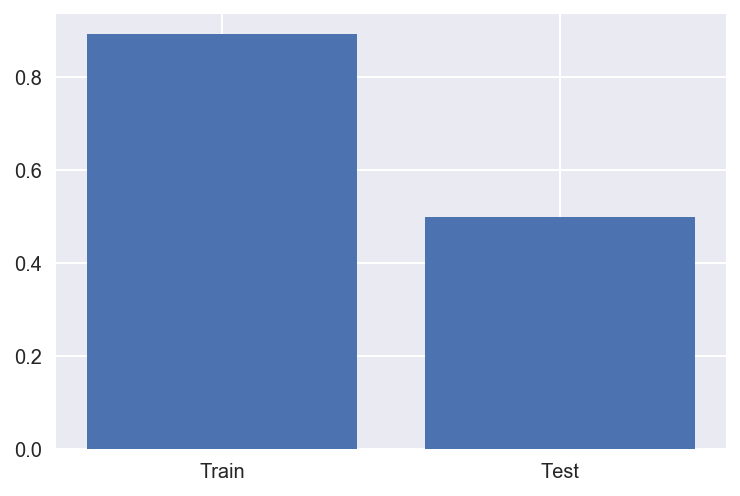

In [71]:
naver_movie_lgb()

---

### 4. 분석(소개(CountVectorizer) + feature 더미 -> LGBClassification 분석)

In [72]:
def CountVectorizer_road_con():
    vect = CountVectorizer()
    vect.fit(total['소개'])
    #vect.vocabulary_
    
    trans = vect.transform(total['소개']).toarray()
    
#     trans = pd.DataFrame(trans, columns=vect.get_feature_names()).to_string()
    trans = pd.DataFrame(trans)
    
    trans['y'] = total['class']
    
    return trans

trans = CountVectorizer_road_con()

In [90]:
trans.tail()

,0,1,2,3,4,5,6,7,8,9,...,37300,37301,37302,37303,37304,37305,37306,37307,37308,y
1710,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,매우어려움
1711,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,매우어려움
1712,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,매우어려움
1713,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,매우어려움
1714,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,매우어려움


In [88]:
def re_data_setting():
    add = total.filter(items=(['걷는길 명칭', '코스명', '지역1', '거리', '상세거리(km)','소요시간']))
    add = pd.get_dummies(add)
    sum_total = pd.concat([trans,add],axis=1)
    
    return sum_total

sum_total = re_data_setting()

In [89]:
sum_total.tail()

,0,1,2,3,4,5,6,7,8,9,...,소요시간_왕복 20분,소요시간_왕복 3시간,소요시간_왕복 40분,소요시간_왕복 4시간 정도,소요시간_왕복 6시간,소요시간_총 10시간,소요시간_총 11시간,소요시간_코스별 1~2시간내외,"소요시간_편도 1시간 30분, 왕복 3시간",소요시간_편도 20분
1710,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1711,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1712,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1713,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1714,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
le = LabelEncoder()

y_train = le.fit_transform(sum_total['y'])
X_train = sum_total.drop("y",axis=1)

print("Start1")
model_1 = lgb.LGBMClassifier(nthread=3)
scores_1 = cross_val_score(estimator=model_1, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_1.mean(), scores_1.std() * 2), '-> None')
print("End")
print(" ")

print("Start2")
model_2 = lgb.LGBMClassifier(nthread=3, reg_alpha=0.5)
scores_2 = cross_val_score(estimator=model_2, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_2.mean(), scores_2.std() * 2), '-> reg_alpha=0.5')
print("End")
print(" ")

print("Start3")
model_3 = lgb.LGBMClassifier(nthread=3, reg_alpha=1)
scores_3 = cross_val_score(estimator=model_3, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_3.mean(), scores_3.std() * 2), '-> reg_alpha=1')
print("End")
print(" ")

print("Start4")
model_4 = lgb.LGBMClassifier(nthread=3, reg_alpha=0.5, learning_rate=0.05, n_estimator=200)
scores_4 = cross_val_score(estimator=model_4, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_4.mean(), scores_4.std() * 2), '-> reg_alpha=0.5, l_r=0.05, n_estimator=200')
print("End")
print(" ")

print("Start5")
model_5 = lgb.LGBMClassifier(nthread=3, reg_alpha=1, learning_rate=0.05, n_estimator=300)
scores_5 = cross_val_score(estimator=model_5, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_5.mean(), scores_5.std() * 2), '-> reg_alpha=1, l_r=0.05, n_estimator=300')
print("End")
print(" ")

print("Trial_Error")
model_6 = lgb.LGBMClassifier(nthread=3, n_estimators=200)
scores_6 = cross_val_score(estimator=model_6, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_6.mean(), scores_6.std() * 2), '-> n_estimator=200')
print("End")
print(" ")

In [83]:
X_train_T, X_test_T, y_train_T, y_test_T = train_test_split(sum_total.drop("y", axis=1), sum_total['y'], \
                                                    test_size=0.2, random_state=0)

len(X_train_T),len(X_test_T),len(y_train_T),len(y_test_T)

(1372, 343, 1372, 343)

In [86]:
def naver_movie_lgb():
    
    model_lgb = lgb.LGBMClassifier(nthread=3, learning_rate=0.3, reg_alpha=0.1, n_estimator=150)
    model_lgb.fit(X_train_T, y_train_T)
    
    y_pred_l = model_lgb.predict(X_train_T)
    
    print("Train", "\n")
    print("Confusion_Matrix", "\n")
    print(confusion_matrix(y_train_T, y_pred_l), "\n\n")

    print("Classification_Report", "\n")
    print(classification_report(y_train_T, y_pred_l), "\n\n")

    print("Accuracy_Score", "\n")
    print(round(accuracy_score(y_train_T, y_pred_l),2), "\n\n")
    
    print("=====================================================" , "\n\n")
    
    y_pred_l_T = model_lgb.predict(X_test_T)
    
    print("Test", "\n")
    print("Confusion_Matrix", "\n")
    print(confusion_matrix(y_test_T, y_pred_l_T), "\n\n")

    print("Classification_Report", "\n")
    print(classification_report(y_test_T, y_pred_l_T), "\n\n")

    print("Accuracy_Score", "\n")
    print(round(accuracy_score(y_test_T, y_pred_l_T),2))
    
    x="Train","Test"
    y=accuracy_score(y_train_T, y_pred_l), accuracy_score(y_test_T, y_pred_l_T)
    plt.bar(x,y)
    plt.show()

Train 

Confusion_Matrix 

[[ 53   0   0  31   0]
 [  0  14   0   0   8]
 [  0   0 760   2   0]
 [ 32   0   1 313   0]
 [  0  14   0   0 144]] 


Classification_Report 

             precision    recall  f1-score   support

       매우쉬움       0.62      0.63      0.63        84
      매우어려움       0.50      0.64      0.56        22
         보통       1.00      1.00      1.00       762
         쉬움       0.90      0.90      0.90       346
        어려음       0.95      0.91      0.93       158

avg / total       0.94      0.94      0.94      1372
 


Accuracy_Score 

0.94 




Test 

Confusion_Matrix 

[[  0   0   2  14   0]
 [  0   0   0   0   3]
 [  1   0 139  37  14]
 [ 22   0  42  31   3]
 [  1   0  23   6   5]] 


Classification_Report 

             precision    recall  f1-score   support

       매우쉬움       0.00      0.00      0.00        16
      매우어려움       0.00      0.00      0.00         3
         보통       0.67      0.73      0.70       191
         쉬움       0.35      0.32      0.33  

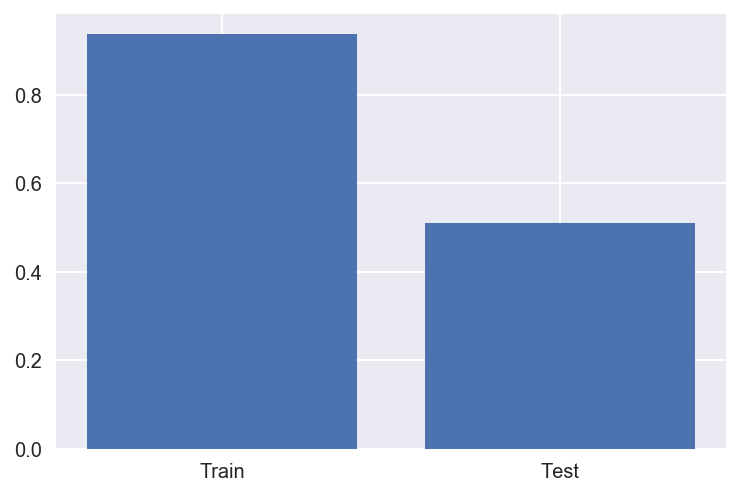

In [87]:
naver_movie_lgb()

---

outcome

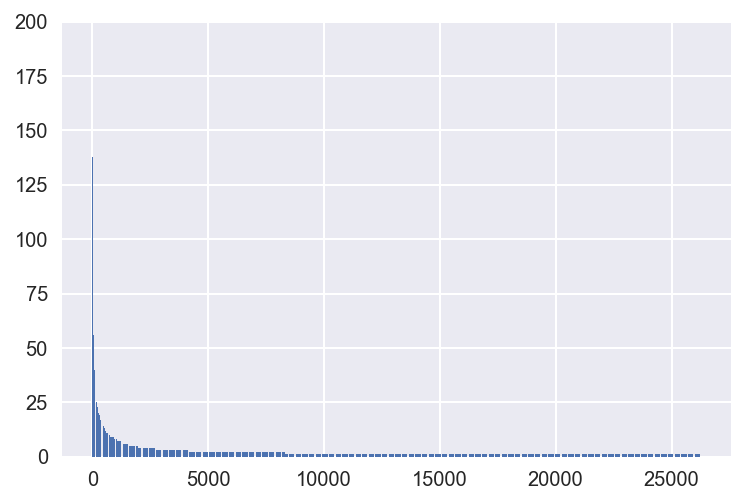

In [18]:
from sklearn.feature_extraction.text import HashingVectorizer
vect = CountVectorizer().fit(X_train_a)
count = vect.transform(X_train_a).toarray().sum(axis=0)
idx = np.argsort(-count)
count = count[idx]
feature_name = np.array(vect.get_feature_names())[idx]
plt.bar(range(len(count)), count)
plt.ylim(0, 200)
plt.show()

In [15]:
print(list(zip(feature_name, count)))

[('있는', 884), ('있다', 767), ('따라', 468), ('길이다', 267), ('있으며', 253), ('지나', 238), ('있어', 237), ('아름다운', 228), ('걷는', 190), ('길을', 177), ('다양한', 155), ('있고', 144), ('함께', 138), ('이어지는', 130), ('코스이다', 126), ('특히', 121), ('느낄', 121), ('한다', 120), ('가장', 119), ('곳이다', 119), ('된다', 113), ('많은', 108), ('길은', 107), ('또한', 102), ('길로', 100), ('가는', 98), ('그리고', 94), ('걷다보면', 91), ('걸을', 91), ('이르는', 81), ('다시', 81), ('좋은', 80), ('등이', 79), ('길이', 78), ('즐길', 77), ('곳으로', 76), ('작은', 75), ('마을', 74), ('많이', 72), ('숲길을', 71), ('지나면', 70), ('조성된', 70), ('조성되어', 66), ('만날', 66), ('코스로', 65), ('거쳐', 64), ('위치한', 62), ('등을', 61), ('위해', 61), ('코스', 60), ('한눈에', 60), ('오르면', 57), ('구간은', 57), ('하는', 57), ('있습니다', 57), ('구간이다', 56), ('좋다', 56), ('걸어', 53), ('이어진다', 53), ('모습을', 53), ('소나무', 53), ('출발하여', 52), ('걷기', 51), ('맑은', 51), ('있도록', 50), ('감상할', 49), ('풍경을', 49), ('같은', 49), ('시원한', 48), ('마치', 48), ('끼고', 46), ('만나게', 46), ('구간으로', 46), ('마을을', 46), ('그대로', 45), ('만나는', 45), ('등의', 45), ('걸으며

---